In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=True)
import warnings
warnings.filterwarnings("ignore")

### merge S19 and S21 with LAMOST DR6

In [3]:
d19 = pd.read_csv("data/santos19.tsv", delimiter='|', comment='#')
d21 = pd.read_csv("data/santos21.tsv", delimiter='|', comment='#')
ds = pd.concat([d19, d21]).reset_index(drop=True)[['KIC', 'Prot', 'Sph']]
ds['kepid'] = ds.KIC
ds['Rper'] = ds.Sph
print (len(ds), "stars in Santos catalog.")

55231 stars in Santos catalog.


In [4]:
dlam = pd.read_csv("data/dr6_kplr.csv", delimiter="|")
dlam = dlam.rename({"# kepid": "kepid"}, axis='columns')

In [5]:
import os
plotdir = 'santos_sample_plots/'
if not os.path.exists(plotdir):
    os.system("mkdir %s"%plotdir)

### check RV difference

In [6]:
drot = pd.merge(ds, dlam, on='kepid', how='left')
print (len(drot), "stars in M14-LAMOST DR6 including duplications.")
print (len(drot.drop_duplicates("kepid", keep='first')), "stars in M14-LAMOST DR6 without duplications.")

62289 stars in M14-LAMOST DR6 including duplications.
55231 stars in M14-LAMOST DR6 without duplications.


In [7]:
rvmin = drot.groupby("kepid", as_index=False).min()[["kepid", "rv"]].rename({"rv": "rvmin"}, axis='columns')
rvmax = drot.groupby("kepid", as_index=False).max()[["kepid", "rv"]].rename({"rv": "rvmax"}, axis='columns')

In [8]:
len(rvmin)

55231

In [9]:
dupids = np.array(drot.kepid[drot.duplicated("kepid", keep='first')])
drv = pd.merge(rvmin, rvmax, on='kepid')
drv['dup'] = drv.kepid.isin(dupids)
drv['rvdiff'] = drv['rvmax'] - drv['rvmin']

SD of RV difference (km/s): 7.972431229249229


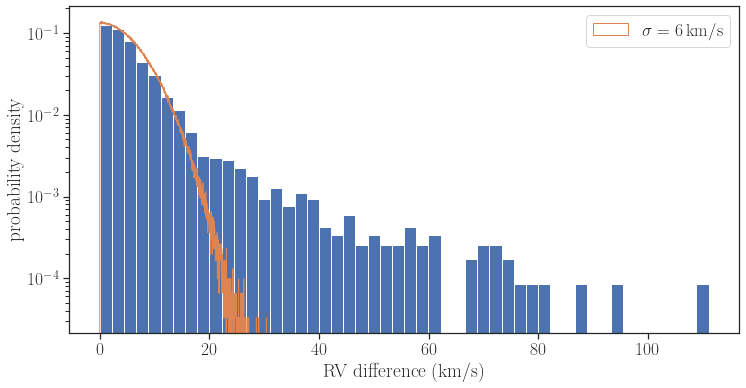

In [10]:
rnds = np.random.randn(int(1e6))*6
print ("SD of RV difference (km/s):", np.std(drv.rvdiff[drv.dup]))
plt.xlabel("RV difference (km/s)")
plt.ylabel("probability density")
plt.yscale("log")
plt.hist(drv.rvdiff[drv.dup], bins=50, density=True)
plt.hist(np.abs(rnds), density=True, bins=1000, histtype='step', label='$\sigma=6\,\mathrm{km/s}$')
plt.legend()
plt.savefig(plotdir+"rvdiff.png", dpi=200, bbox_inches="tight")

In [11]:
print (len(dlam.groupby('kepid', as_index=False).mean()), "Kepler stars in LAMOST DR6.")

61280 Kepler stars in LAMOST DR6.


In [12]:
drot = pd.merge(ds, dlam.groupby('kepid', as_index=False).mean().reset_index(drop=True), on='kepid')
drot = pd.merge(drot, drv, on='kepid')
print (len(drot), "stars in the sample.")

15936 stars in the sample.


### xmatch with Gaia, remove photometric binaries and evolved stars

In [13]:
dgaia = pd.read_csv("data/kepler_gaiaedr3_cds.csv")
dgaia['kepid'] = dgaia.KIC
dkic = pd.read_csv("data/kepler_stellar_17.csv", comment='#', delimiter="|")
dgaia = pd.merge(dgaia, dkic[['kepid', 'kepmag']], on='kepid')

In [14]:
print (len(dgaia), "Gaia matches within 5 arcsec.")

267750 Gaia matches within 5 arcsec.


In [15]:
d = pd.merge(drot, dgaia, how='left', on='kepid')
d['darcsec'] = d.angDist
d['GminK'] = d.phot_g_mean_mag - d.kepmag
d['mg'] = d.phot_g_mean_mag + 5 * np.log10(d.parallax) - 10

In [16]:
print (len(d), 'sources.')
print (np.sum(d.duplicated("kepid")), 'duplications.')

21781 sources.
5845 duplications.


In [17]:
def check_multis(d):
    plt.xlabel("distance (arcsec)")
    plt.ylabel("$G-K_p$")
    plt.xscale("log")
    plt.plot(d.darcsec, d.GminK, '.')
    kepids = list(d.kepid[d.kepid.duplicated(keep="first")])
    for _kepid in kepids:
        _idx = d.kepid==_kepid
        plt.plot(d.darcsec[_idx], d.GminK[_idx], 'o-', mfc="none", color="C1", lw=0.)

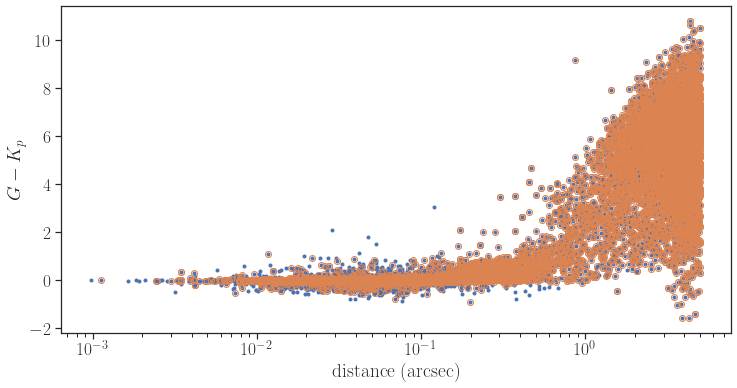

In [18]:
check_multis(d)

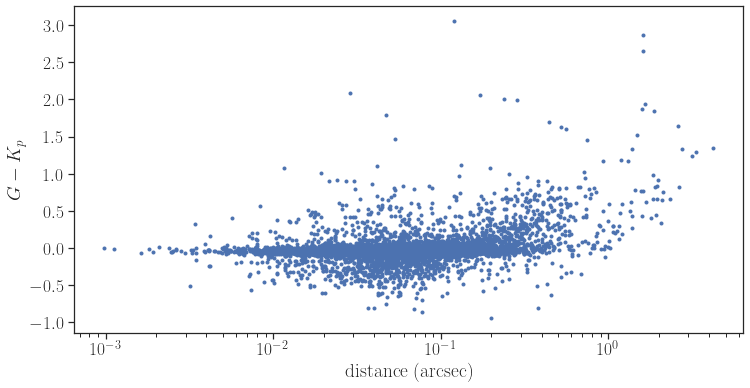

In [19]:
d1 = d.sort_values("darcsec", ascending=True).drop_duplicates("kepid", keep="first").reset_index(drop=True)
d1 = d1[d1.parallax_over_error>10].reset_index(drop=True)
check_multis(d1)

In [20]:
print (len(d1), "sources with Gaia info.")
print ("mean and standard dev of G minus K:", np.mean(d1.GminK), np.std(d1.GminK))
print ("mean and 99% distance:", np.mean(d1.darcsec), np.percentile(d1.darcsec, 99))

15206 sources with Gaia info.
mean and standard dev of G minus K: -0.027798096540839267 0.13802583083985714
mean and 99% distance: 0.08635980422201778 0.46989540000000185


In [21]:
def iterative_fit(x, y, order, nsigma=[1.,3.], maxniter=10):
    A = np.vander(x, order+1)
    idx = np.ones_like(x) > 0
    for i in range(maxniter):
        w = np.linalg.solve(np.dot(A[idx].T, A[idx]), np.dot(A[idx].T, y[idx]))
        mu = np.dot(A, w)
        res = y - mu
        sigma = np.sqrt(np.median(res**2))
        idx_new = (res > -nsigma[0]*sigma) & (res < nsigma[1]*sigma)
        if np.sum(idx)==np.sum(idx_new):
            idx = idx_new
            break
        idx = idx_new
    return mu, w

In [22]:
idx = (d1.teff>4000) & (d1.teff<6500) & (d1.mg>0)
x, y = np.array((d1.teff[idx]-5500)/500), np.array(d1.mg[idx])
t0 = np.linspace(4000, 6500, 100)
x0 = (t0 - 5500) / 500.

In [23]:
order = 5
mu, w = iterative_fit(x, y, order)
msfunc = lambda teff: np.dot(np.vander((teff - 5500) / 500., order+1), w)

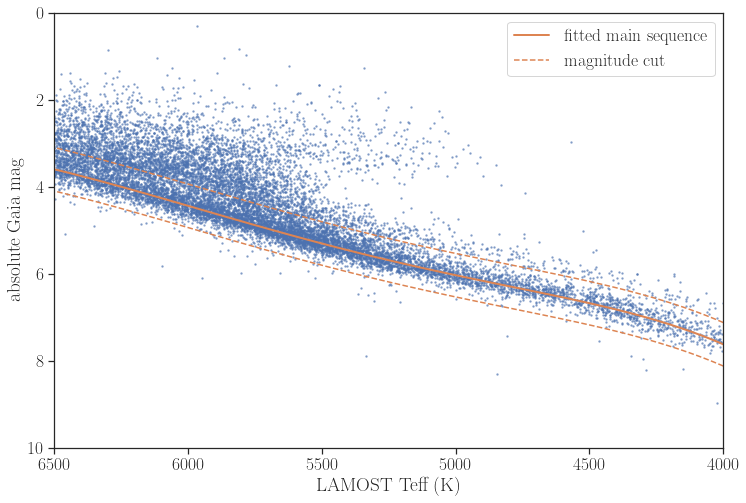

In [24]:
plt.figure(figsize=(12,8))
plt.xlabel("LAMOST Teff (K)")
plt.ylabel("absolute Gaia mag")
plt.xlim(6500, 4000)
plt.ylim(10, 0)
plt.plot(d1.teff, d1.mg, '.', markersize=3, alpha=0.5)
#plt.plot(t0, func((t0-5500)/500.), '-')
plt.plot(t0, msfunc(t0), '-', color='C1', lw=2, label='fitted main sequence')
plt.plot(t0, msfunc(t0)-0.5, '--', color='C1', label='magnitude cut')
plt.plot(t0, msfunc(t0)+0.5, '--', color='C1')
plt.legend(loc='best')
plt.savefig(plotdir+"mg_teff_all.png", dpi=200, bbox_inches="tight")

In [25]:
idxrv = d1.rvdiff > 20
idxmg = np.abs(d1.mg - msfunc(d1.teff)) > 0.5
idxt = (d1.teff>4000) & (d1.teff<6500)
idx = ((~idxrv) & (~idxmg)) & idxt 
#idx &= (d1.ruwe<1.4)

In [26]:
print ("after M_G and teff cut:", np.sum(~idxmg&idxt))
print ("after M_G and teff and RV cut:", np.sum((~idxmg)&idxt&(~idxrv)))

after M_G and teff cut: 8817
after M_G and teff and RV cut: 8734


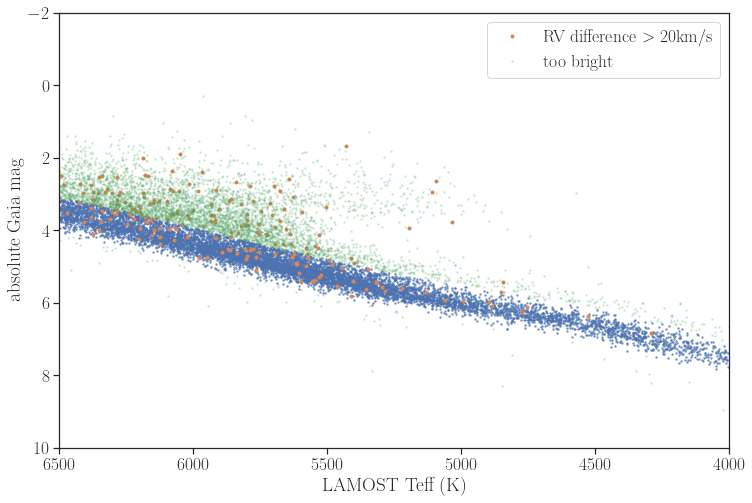

In [27]:
plt.figure(figsize=(12,8))
plt.xlabel("LAMOST Teff (K)")
plt.ylabel("absolute Gaia mag")
plt.xlim(6500, 4000)
plt.ylim(10, -2)
plt.plot(d1.teff[idx], d1.mg[idx], '.', markersize=3, alpha=0.6)
plt.plot(d1.teff[idxrv], d1.mg[idxrv], '.', label='RV difference $> 20$km/s')
plt.plot(d1.teff[idxmg], d1.mg[idxmg], '.', alpha=0.2, color='C2', markersize=3, label='too bright')
plt.legend(loc='best')
plt.savefig(plotdir+"mg_teff_cut.png", dpi=200, bbox_inches="tight")

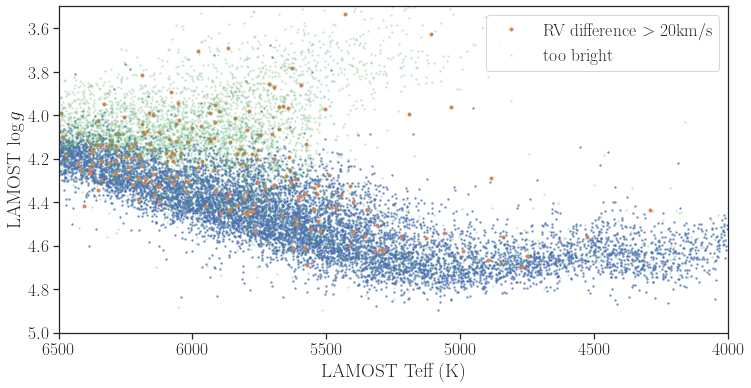

In [28]:
plt.xlabel("LAMOST Teff (K)")
plt.ylabel("LAMOST $\log g$")
plt.xlim(6500, 4000)
plt.ylim(5, 3.5)
plt.plot(d1.teff[idx], d1.logg[idx], '.', markersize=3, alpha=0.6)
plt.plot(d1.teff[idxrv], d1.logg[idxrv], '.', label='RV difference $> 20$km/s')
plt.plot(d1.teff[idxmg], d1.logg[idxmg], '.', alpha=0.2, color='C2', markersize=3, label='too bright')
plt.legend(loc='best')
#plt.plot(t0, logg0)
plt.savefig(plotdir+"logg_teff_cut.png", dpi=200, bbox_inches="tight")

### assign Kepler precision and Rossby number

In [29]:
from scipy.interpolate import interp1d
dprec = pd.read_csv("data/kepler_precision.txt", delim_whitespace=True)
kepsigma = interp1d(dprec.kepmag, dprec.long, kind='cubic')

# Jenkins et al. (2010)
def sigma_jenkins(kp):
    c = 3.46 * 10**(0.4*(12.-kp)+8.)
    return np.sqrt(c+7e7)/c * 1e6 # upper
    #return np.sqrt(c+7e6*np.fmax(1.,kp/14.)**4) / c * 1e6 # lower

In [30]:
def tau_g98(teff):
    return 314.24 * np.exp(-(teff/1952.5)-(teff/6250.)**18) + 0.002

#def tau_w11(teff):
#    mass = teff_to_mass(teff)
#    logm = np.log10(mass)
#    logtau = 1.16 - 1.49 * logm - 0.54 * logm * logm
#    return 10**logtau

In [31]:
d1['kepler_sigma'] = kepsigma(d1.kepmag)
d1['kepler_sigma_j'] = sigma_jenkins(d1.kepmag)
d1['tau'] = tau_g98(d1.teff)
d1['Rnorm'] = d1.Rper / d1.kepler_sigma
d1['Pnorm'] = d1.Prot / d1.tau

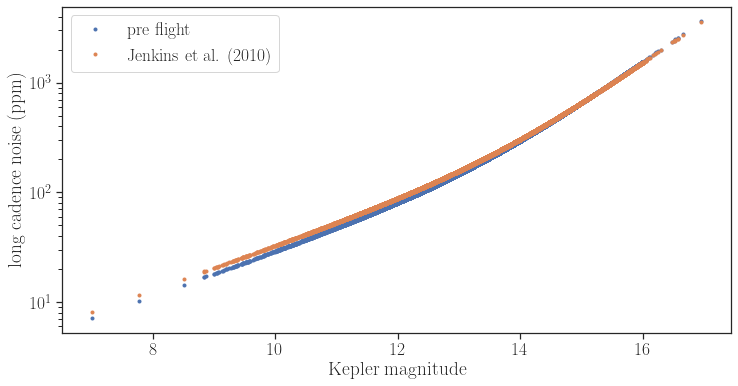

In [32]:
plt.yscale("log")
plt.plot(d1.kepmag, d1.kepler_sigma, '.', label='pre flight')
plt.plot(d1.kepmag, d1.kepler_sigma_j*1.5, '.', label='Jenkins et al. (2010)')
plt.ylabel("long cadence noise (ppm)")
plt.xlabel("Kepler magnitude")
plt.legend(loc='best');

### plots

In [33]:
rnlabel = "variability amplitude $S_\mathrm{ph}$\n normalized by Kepler photometric precision"
rlabel = "variability amplitude $S_\mathrm{ph}$ (ppm)"
pnlabel = r"$\mathrm{Ro}=P_\mathrm{rot}/\tau_\mathrm{c}$"
dtlabel = "empirical threshold\nin the McQuillan sample"#'empirical detection threshold'
tefflabel = 'LAMOST $T_\mathrm{eff}$ (K)'
protlabel = 'rotation period $P_\mathrm{rot}$ (days)'
col = 'gray'

In [34]:
dclean = d1[idx&(d1.logg>4.)].reset_index(drop=True)
print (len(dclean), "stars in the final sample.")

8713 stars in the final sample.


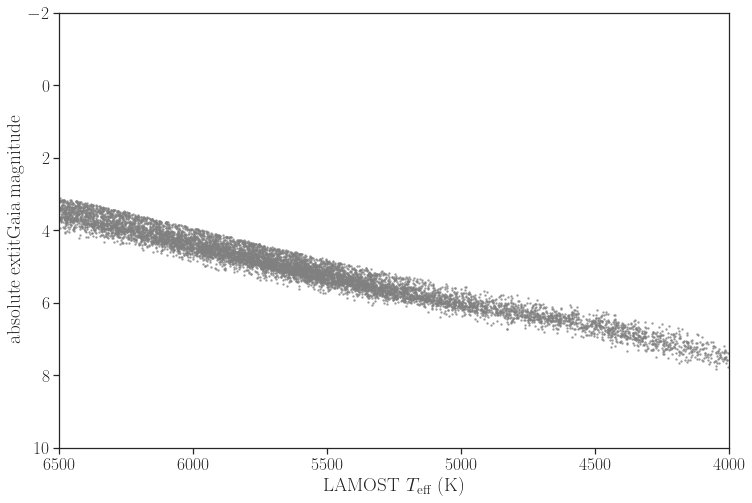

In [35]:
plt.figure(figsize=(12,8))
plt.xlabel(tefflabel)
plt.ylabel("absolute \textit{Gaia} magnitude")
plt.xlim(6500, 4000)
plt.ylim(10, -2)
plt.plot(dclean.teff, dclean.mg, '.', markersize=3, alpha=0.6, color=col)
#plt.plot(dclean.teff[idxg], dclean.mg[idxg], '.', markersize=10, alpha=0.6, label='$\log g<4$')
#plt.legend(loc='best')
plt.savefig(plotdir+"mg_teff_cut.png", dpi=200, bbox_inches="tight")

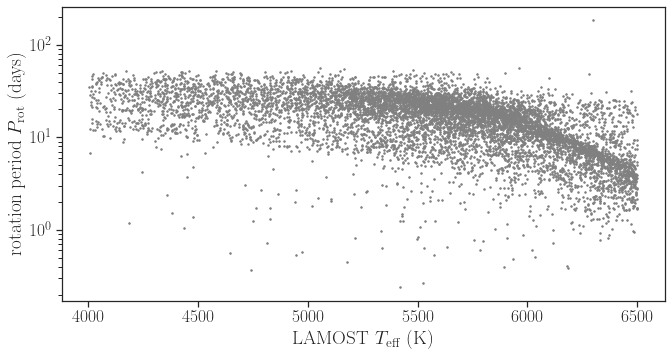

In [36]:
plt.figure(figsize=(12*0.9,6*0.9))
plt.xlabel(tefflabel)
plt.ylabel(protlabel)
plt.yscale("log")
plt.plot(dclean.teff, dclean.Prot, '.', markersize=3, color=col)
plt.savefig(plotdir+"prot_teff.png", dpi=200, bbox_inches="tight")

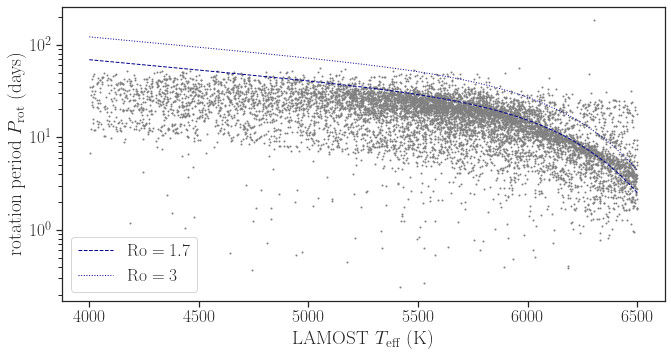

In [37]:
plt.figure(figsize=(12*0.9,6*0.9))
t0 = np.linspace(4000, 6500, 100)
plt.xlabel(tefflabel)
plt.ylabel(protlabel)
plt.yscale("log")
plt.plot(dclean.teff, dclean.Prot, '.', markersize=2, color=col)
plt.plot(t0, tau_g98(t0)*1.7, ls='dashed', color='darkblue', lw=1, label='$\mathrm{Ro}=1.7$')
plt.plot(t0, tau_g98(t0)*3, ls='dotted', color='darkblue', lw=1, label='$\mathrm{Ro}=3$')
plt.legend(loc='lower left')
plt.savefig(plotdir+"prot_teff_rocut.png", dpi=200, bbox_inches="tight")

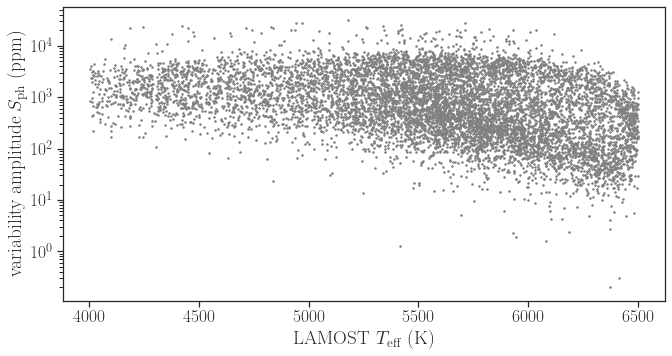

In [38]:
plt.figure(figsize=(12*0.9,6*0.9))
plt.xlabel(tefflabel)
plt.ylabel(rlabel)
plt.yscale("log")
plt.plot(dclean.teff, dclean.Rper, '.', markersize=3, color=col)
plt.savefig(plotdir+"rper_teff.png", dpi=200, bbox_inches="tight");

In [39]:
dm = pd.merge(ds, dkic[['kepid', 'kepmag']], on='kepid')
dm['kepmag'][dm.kepmag<7] = 7
dm['kepsigma'] = kepsigma(dm.kepmag)

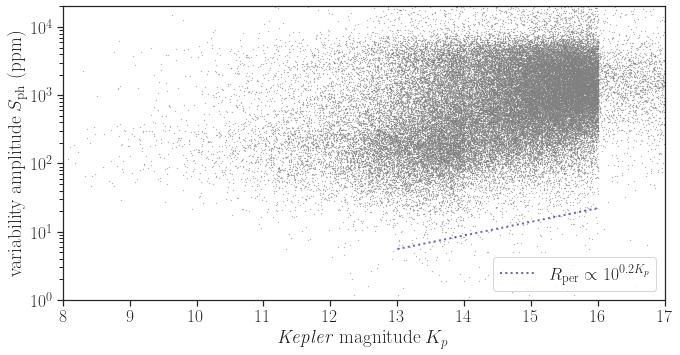

In [40]:
plt.figure(figsize=(12*0.9,6*0.9))
k0 = np.linspace(13, 16, 100)
plt.xlabel(r"\textit{Kepler} magnitude $K_p$")
plt.ylabel(rlabel)
plt.xlim(8, 17)
#plt.ylim(5e1, 1e6)
plt.ylim(5e1/50, 1e6/50.)
plt.yscale("log")
#plt.plot(dclean.kepmag, dclean.Rper, '.', markersize=3, color=col)
plt.plot(dm.kepmag, dm.Rper, '.', markersize=0.5, color=col)
plt.plot(k0, 0.7*10**(0.2*k0)/50., color='darkblue', lw=2, ls='dotted', alpha=0.6, 
         label="$R_\mathrm{per}\propto 10^{0.2K_p}$")
plt.legend(loc='lower right')
plt.savefig(plotdir+"rper_kepmag_santos.png", dpi=200, bbox_inches="tight")

In [41]:
R_th = 3/3.6
R1 = np.percentile(dclean.Rnorm, 2)
print (R1)

0.1400650633907093


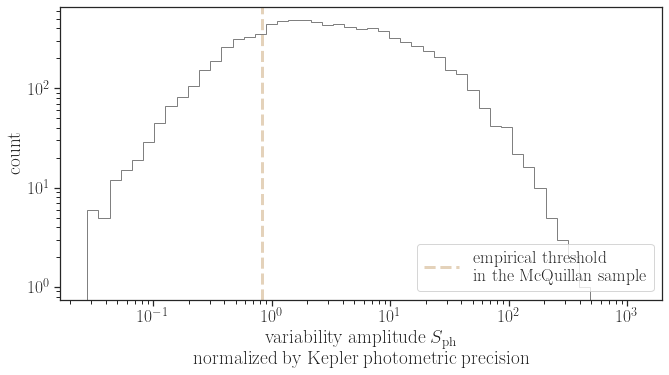

In [42]:
plt.figure(figsize=(12*0.9,6*0.9))
bins = np.logspace(-2, 3.5, 50) / 50.
bins = np.logspace(np.log10(0.1), np.log10(4.2e3), 50) / 3.6
plt.xlabel(rnlabel)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("count")
plt.axvline(x=R_th, label=dtlabel, 
            color='tan', lw=3, ls='dashed', alpha=0.6,)
plt.hist(dclean.Rnorm, bins=bins, histtype='step', lw=1, color=col)
plt.legend(loc='lower right')
plt.savefig(plotdir+"rper_hist_santos.png", dpi=200, bbox_inches="tight")

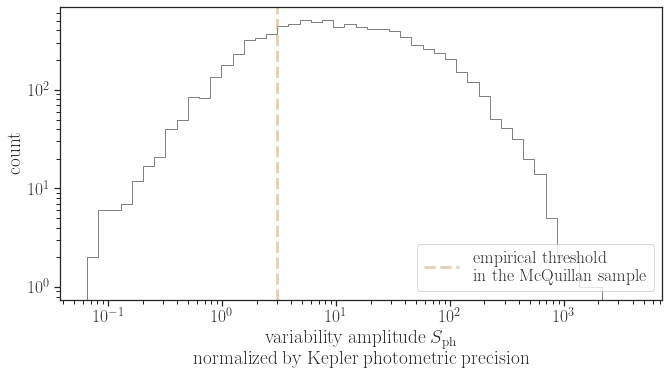

In [43]:
plt.figure(figsize=(12*0.9,6*0.9))
bins = np.logspace(np.log10(0.65/10.), np.log10(4.2e3), 50) 
plt.xlabel(rnlabel)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("count")
plt.axvline(x=3, label=dtlabel, 
            color='tan', lw=3, ls='dashed', alpha=0.6,)
plt.hist(dclean.Rnorm*3.6, bins=bins, histtype='step', lw=1, color=col)
plt.legend(loc='lower right')
plt.savefig(plotdir+"rper_hist_santos2.png", dpi=200, bbox_inches="tight")

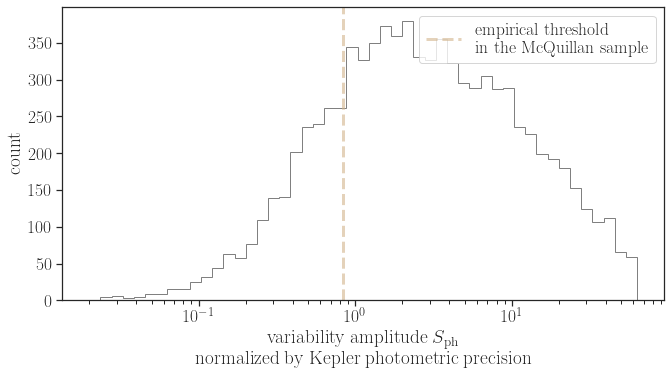

In [44]:
plt.figure(figsize=(12*0.9,6*0.9))
R1 = np.percentile(dclean.Rnorm, 2)
bins = np.logspace(0, 3.5, 50)/50.
plt.xlabel(rnlabel)
#plt.yscale("log")
plt.xscale("log")
plt.ylabel("count")
plt.axvline(x=R_th, label=dtlabel, 
            color='tan', lw=3, ls='dashed', alpha=0.6,)
plt.hist(dclean.Rnorm, bins=bins, histtype='step', lw=1, color=col)
plt.legend(loc='best')
plt.savefig(plotdir+"rper_hist_lin.png", dpi=200, bbox_inches="tight")

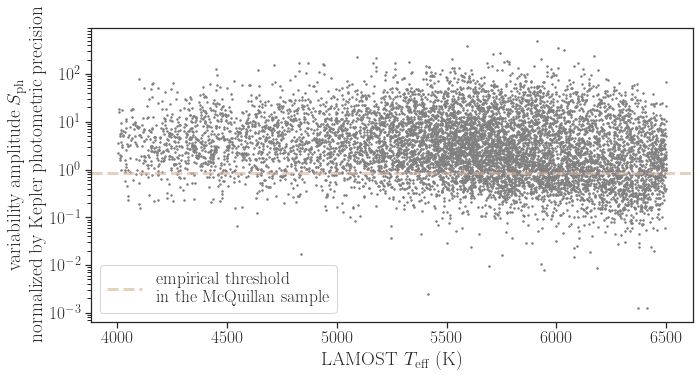

In [45]:
plt.figure(figsize=(12*0.9,6*0.9))
plt.xlabel(tefflabel)
plt.ylabel(rnlabel)
plt.yscale("log")
#plt.ylim(0, 10)
plt.plot(dclean.teff, dclean.Rnorm, '.', markersize=3, color=col)
plt.axhline(y=R_th, color='tan', lw=3, ls='dashed', alpha=0.6, label=dtlabel)
plt.legend(loc='best')
plt.savefig(plotdir+"rnorm_teff.png", dpi=200, bbox_inches="tight")

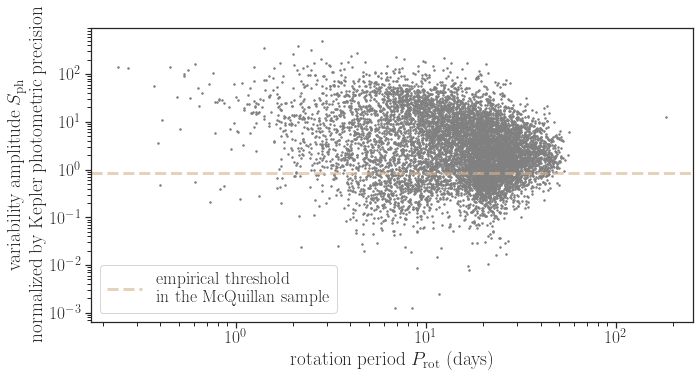

In [46]:
plt.figure(figsize=(12*0.9,6*0.9))
plt.xlabel(protlabel)
plt.ylabel(rnlabel)
plt.xscale("log")
plt.yscale("log")
plt.plot(dclean.Prot, dclean.Rnorm, '.', markersize=3, color=col)
plt.axhline(y=R_th, color='tan', lw=3, ls='dashed', alpha=0.6, label=dtlabel)
plt.legend(loc='best')
plt.savefig(plotdir+"rnorm_prot.png", dpi=200, bbox_inches="tight")

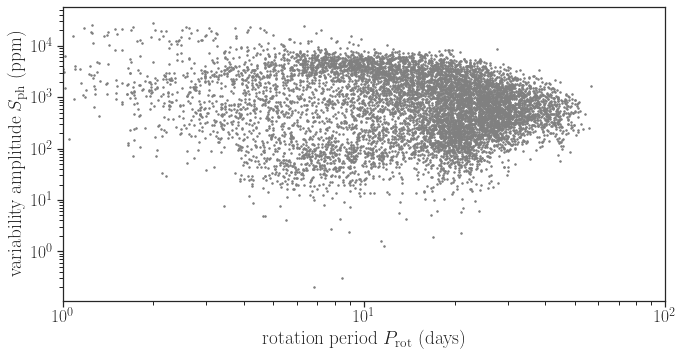

In [47]:
plt.figure(figsize=(12*0.9,6*0.9))
plt.xlim(1, 100)
plt.xlabel(protlabel)
plt.ylabel(rlabel)
plt.yscale("log")
plt.xscale("log")
plt.plot(dclean.Prot, dclean.Rper, '.', markersize=3, color=col)
plt.savefig(plotdir+"rper_prot.png", dpi=200, bbox_inches="tight")

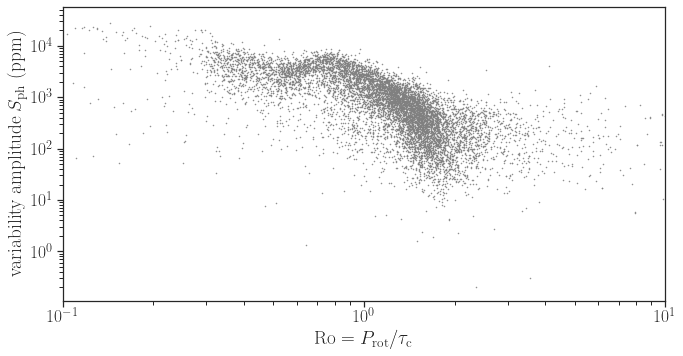

In [48]:
r0 = np.logspace(0, 0.5, 100)
plt.figure(figsize=(12*0.9,6*0.9))
plt.xlabel(pnlabel)
plt.ylabel(rlabel)
plt.yscale("log")
plt.xscale("log")
plt.xlim(0.1, 10)
plt.plot(dclean.Pnorm, dclean.Rper, '.', markersize=1., color=col)
plt.savefig(plotdir+"rper_ro.png", dpi=200, bbox_inches="tight")

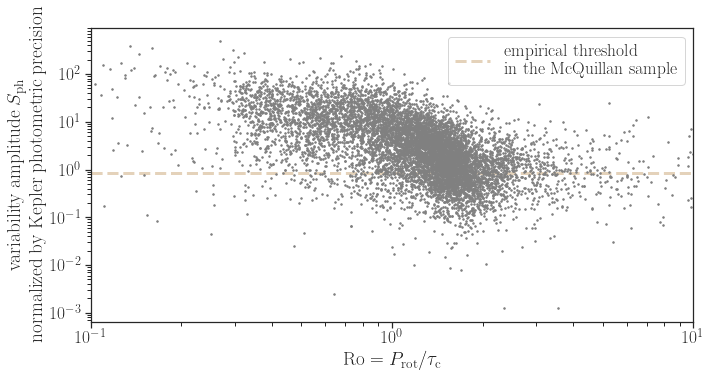

In [49]:
plt.figure(figsize=(12*0.9,6*0.9))
plt.xlabel(pnlabel)
plt.ylabel(rnlabel)
plt.yscale("log")
plt.xscale("log")
plt.xlim(0.1, 10)
plt.axhline(y=R_th, color='tan', lw=3, ls='dashed', alpha=0.6, label=dtlabel)
plt.plot(dclean.Pnorm, dclean.Rnorm, '.', markersize=3, color=col)
plt.legend(loc='best')
plt.savefig(plotdir+"rnorm_ro.png", dpi=200, bbox_inches="tight")

In [50]:
d1.to_csv("santos_sample_all.csv", index=False)
dclean.to_csv("santos_sample_clean.csv", index=False)

## McQuiilan vs Santos

In [203]:
idxc = (np.abs(dclean.Pnorm-1.6)<0.4)&(d.Rper<100)

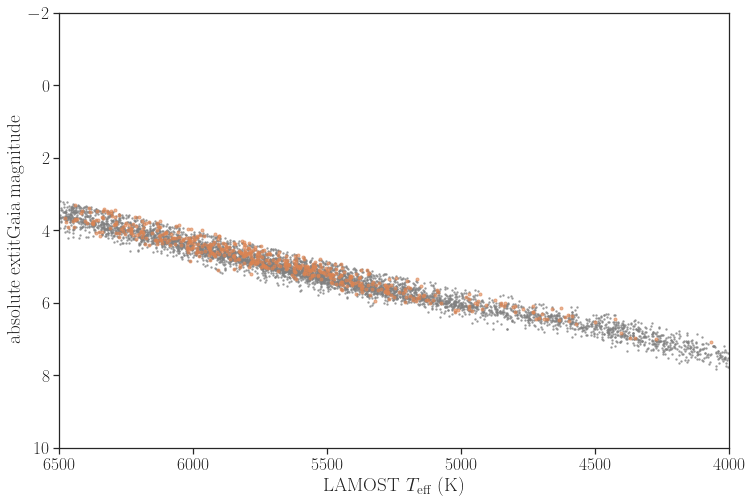

In [207]:
plt.figure(figsize=(12,8))
plt.xlabel(tefflabel)
plt.ylabel("absolute \textit{Gaia} magnitude")
plt.xlim(6500, 4000)
plt.ylim(10, -2)
plt.plot(dmac.teff, dmac.mg, '.', markersize=3, alpha=0.6, color='gray')
plt.plot(dclean.teff[idxc], dclean.mg[idxc], 'o', markersize=3, alpha=0.6, color='C1')

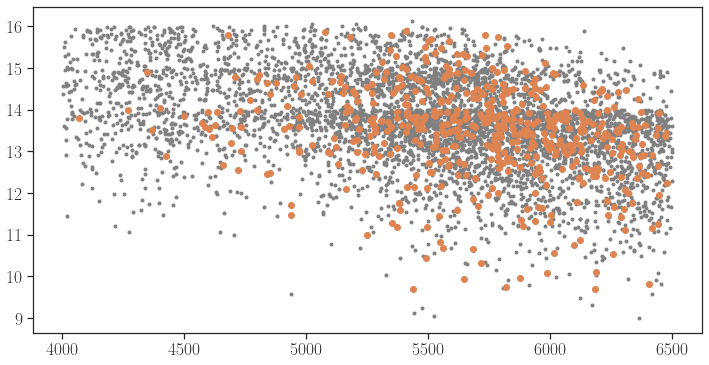

In [209]:
plt.plot(dmac.teff, dmac.kepmag, '.', color='gray')
plt.plot(dclean.teff[idxc], dclean.kepmag[idxc], 'o', color='C1')

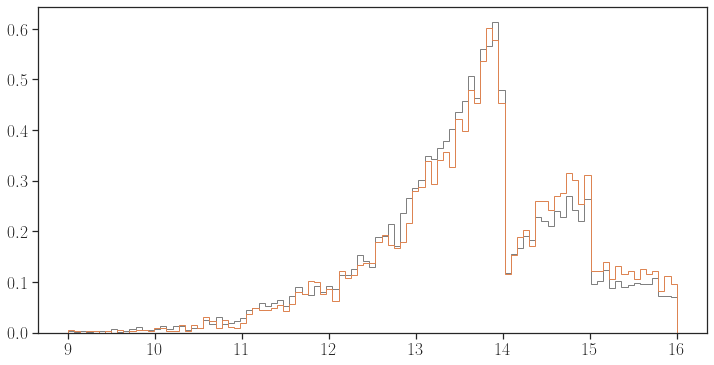

In [164]:
k0 = np.linspace(9, 16, 100)
plt.hist(dclean.kepmag, bins=k0, color='gray', histtype='step', lw=1, density=True)
plt.hist(dmac.kepmag, bins=k0, color='C1', histtype='step', lw=1, density=True);

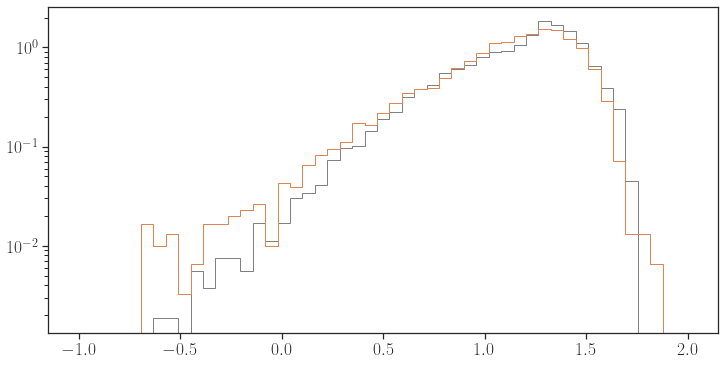

In [172]:
k0 = np.linspace(-1, 2, 50)
#plt.xscale("log")
plt.yscale("log")
plt.hist(np.log10(dclean.Prot), bins=k0, color='gray', histtype='step', lw=1, density=True)
plt.hist(np.log10(dmac.Prot), bins=k0, color='C1', histtype='step', lw=1, density=True);

In [182]:
newidx = ~dclean.kepid.isin(dmac.kepid)

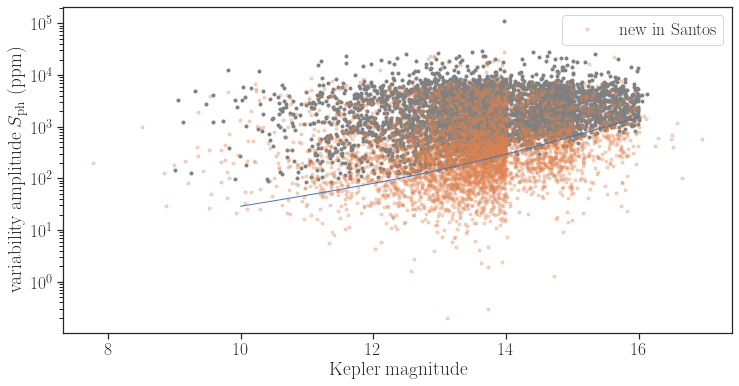

In [246]:
k0 = np.linspace(10, 16, 100)
plt.ylabel(rlabel)
plt.xlabel("Kepler magnitude")
plt.yscale("log")
plt.plot(dmac.kepmag, dmac.Rper/3., '.', color='gray')
plt.plot(dclean.kepmag[newidx], dclean.Rper[newidx], '.', color='C1', alpha=0.3, label='new in Santos')
plt.plot(k0, kepsigma(k0), lw=1)
plt.legend();

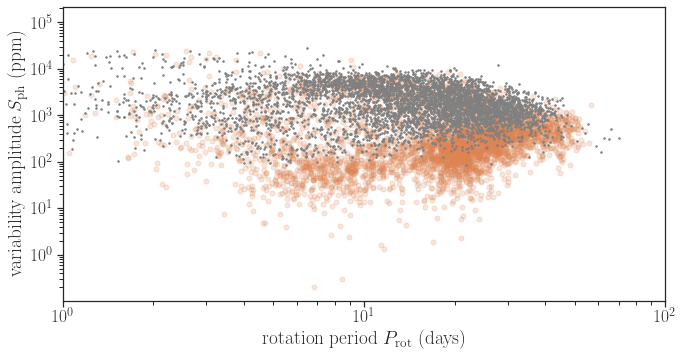

In [232]:
plt.figure(figsize=(12*0.9,6*0.9))
plt.xlim(1, 100)
plt.xlabel(protlabel)
plt.ylabel(rlabel)
plt.yscale("log")
plt.xscale("log")
plt.plot(dclean.Prot[newidx], dclean.Rper[newidx], 'o', markersize=5, color='C1', alpha=0.2)
plt.plot(dmac.Prot, dmac.Rper/3., '.', markersize=3, color=col)
#plt.savefig(plotdir+"rper_prot.png", dpi=200, bbox_inches="tight")

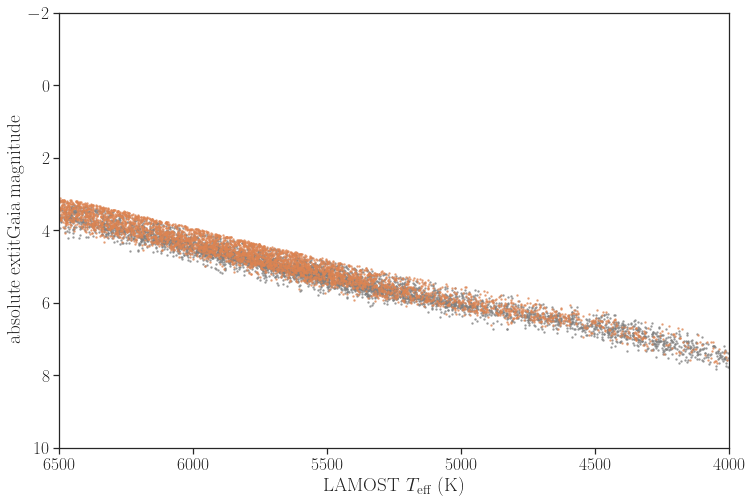

In [191]:
plt.figure(figsize=(12,8))
plt.xlabel(tefflabel)
plt.ylabel("absolute \textit{Gaia} magnitude")
plt.xlim(6500, 4000)
plt.ylim(10, -2)
plt.plot(dmac.teff, dmac.mg, '.', markersize=3, alpha=0.6, color='gray')
plt.plot(dclean.teff[newidx], dclean.mg[newidx], '.', markersize=3, alpha=0.6, color='C1')

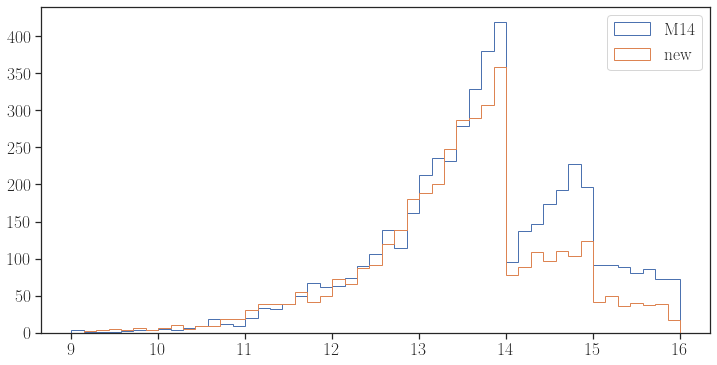

In [199]:
bins = np.linspace(9, 16, 50)
plt.hist(dmac.kepmag, bins=bins, histtype='step', lw=1, label='M14')
plt.hist(dclean.kepmag[newidx], bins=bins, histtype='step', lw=1, label='new')
plt.legend();

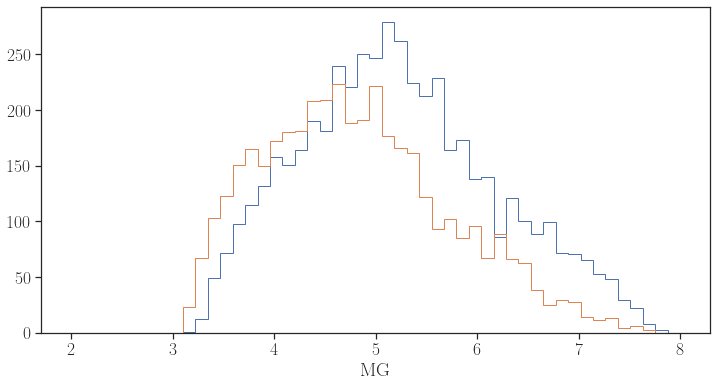

In [200]:
bins = np.linspace(2, 8, 50)
plt.xlabel("MG")
plt.hist(dmac.mg, bins=bins, histtype='step', lw=1)
plt.hist(dclean.mg[newidx], bins=bins, histtype='step', lw=1);

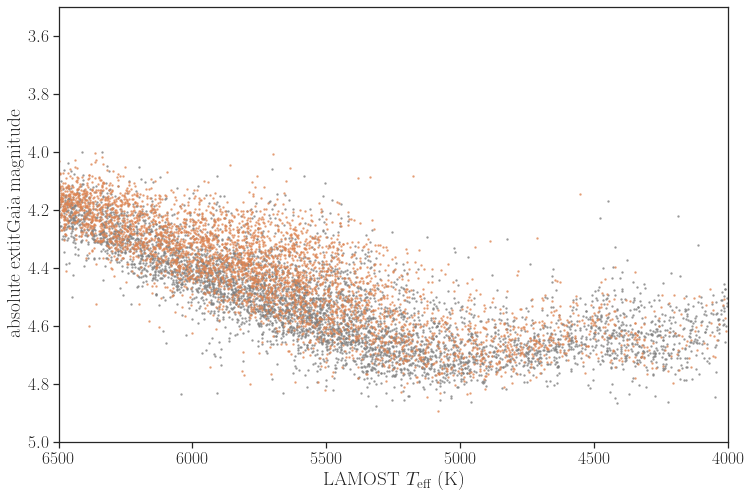

In [190]:
plt.figure(figsize=(12,8))
plt.xlabel(tefflabel)
plt.ylabel("absolute \textit{Gaia} magnitude")
plt.xlim(6500, 4000)
plt.ylim(5, 3.5)
plt.plot(dmac.teff, dmac.logg, '.', markersize=3, alpha=0.6, color='gray')
plt.plot(dclean.teff[newidx], dclean.logg[newidx], '.', markersize=3, alpha=0.6, color='C1')